In [1]:
# Importing general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer

# Importing models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Importing metrics
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, roc_curve, auc
import warnings

# Importing stats
from scipy.stats import shapiro, kruskal, probplot, ranksums
from sklearn.utils import resample
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm

# Don't show warnings
warnings.filterwarnings('ignore')

/var/folders/tc/p_2dw00d5zg0svx3_qj__8tc0000gn/T/ipykernel_54942/4191893726.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Loading data
df = pd.read_csv('HR_data.csv')
df.head()

,Unnamed: 0,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
0,0,77.965186,78.00,3.345290,73.23,83.37,22924.945,round_3,phase3,1,1,1,D1_1
1,1,70.981097,70.57,2.517879,67.12,78.22,21930.400,round_3,phase2,1,1,5,D1_1
2,2,73.371959,73.36,3.259569,67.88,80.22,21647.085,round_3,phase1,1,1,0,D1_1
3,3,78.916822,77.88,4.054595,72.32,84.92,25258.905,round_2,phase3,1,1,1,D1_1
4,4,77.322226,74.55,6.047603,70.52,90.15,23890.565,round_2,phase2,1,1,5,D1_1


In [3]:
# Defining Features
features = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC', 'Round', 'Phase', 'Puzzler', 'Cohort']
# Defining Target
target = 'Frustrated'
# Defining Group
Group = 'Individual'

# Splitting data
X = df[features]
y = df[target]
groups = df[Group]


In [4]:
# For later Preprocessing (See CV loop)
num_features = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']
cat_features = ['Round', 'Phase', 'Puzzler', 'Cohort']

In [5]:
# Defining models
models = {
    'Baseline': DummyClassifier(strategy="most_frequent"),
    'MLR': LogisticRegression(solver='lbfgs', C=0.5, max_iter=100, multi_class='multinomial'),
    'ANN': MLPClassifier(hidden_layer_sizes=(100,50), activation='relu', solver='adam', learning_rate='constant', learning_rate_init=0.1, max_iter=5000),
    'SVM': SVC(kernel='linear', C=1, gamma='scale'),
    'RF': RandomForestClassifier(n_estimators=100, max_features='log2', max_depth=10, criterion='gini')
}

# target labels (not used)
all_labels = np.arange(11)

# Definining colors for each model
colors = {
    'Baseline': 'blue',
    'MLR': 'green',
    'ANN': 'red',
    'SVM': 'purple',
    'RF': 'orange'
}

In [6]:
# Conducting Cross-validation on multiple seeds
n_iterations = 20 # 20 random seeds
results = {name: {'cv_f1_scores': [], 'cv_mse_scores': []} for name in models.keys()}

for seed in tqdm(range(n_iterations), desc="Cross-validation Iterations"):
    np.random.seed(seed)
    logo = LeaveOneGroupOut()
    
    for train_index, test_index in logo.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_train, groups_test = groups.iloc[train_index], groups.iloc[test_index]

        for name, model in models.items():
            f1_scores = []
            mse_scores = []

            for train_idx, test_idx in logo.split(X_train, y_train, groups=groups_train):
                X_train_cv, X_test_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
                y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]

                # Standardising the data
                preprocessor = ColumnTransformer(
                    transformers=[
                        ('num', StandardScaler(), num_features),
                        ('cat', OneHotEncoder(), cat_features)
                    ]
                )

                X_train_cv = preprocessor.fit_transform(X_train_cv)
                X_test_cv = preprocessor.transform(X_test_cv)

                model.fit(X_train_cv, y_train_cv)
                y_pred_cv = model.predict(X_test_cv)

                f1_scores.append(f1_score(y_test_cv, y_pred_cv, average='weighted'))
                mse_scores.append(mean_squared_error(y_test_cv, y_pred_cv))

            results[name]['cv_f1_scores'].extend(f1_scores)
            results[name]['cv_mse_scores'].extend(mse_scores)

Cross-validation Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Cross-validation Iterations: 100%|██████████| 20/20 [15:32<00:00, 46.64s/it]


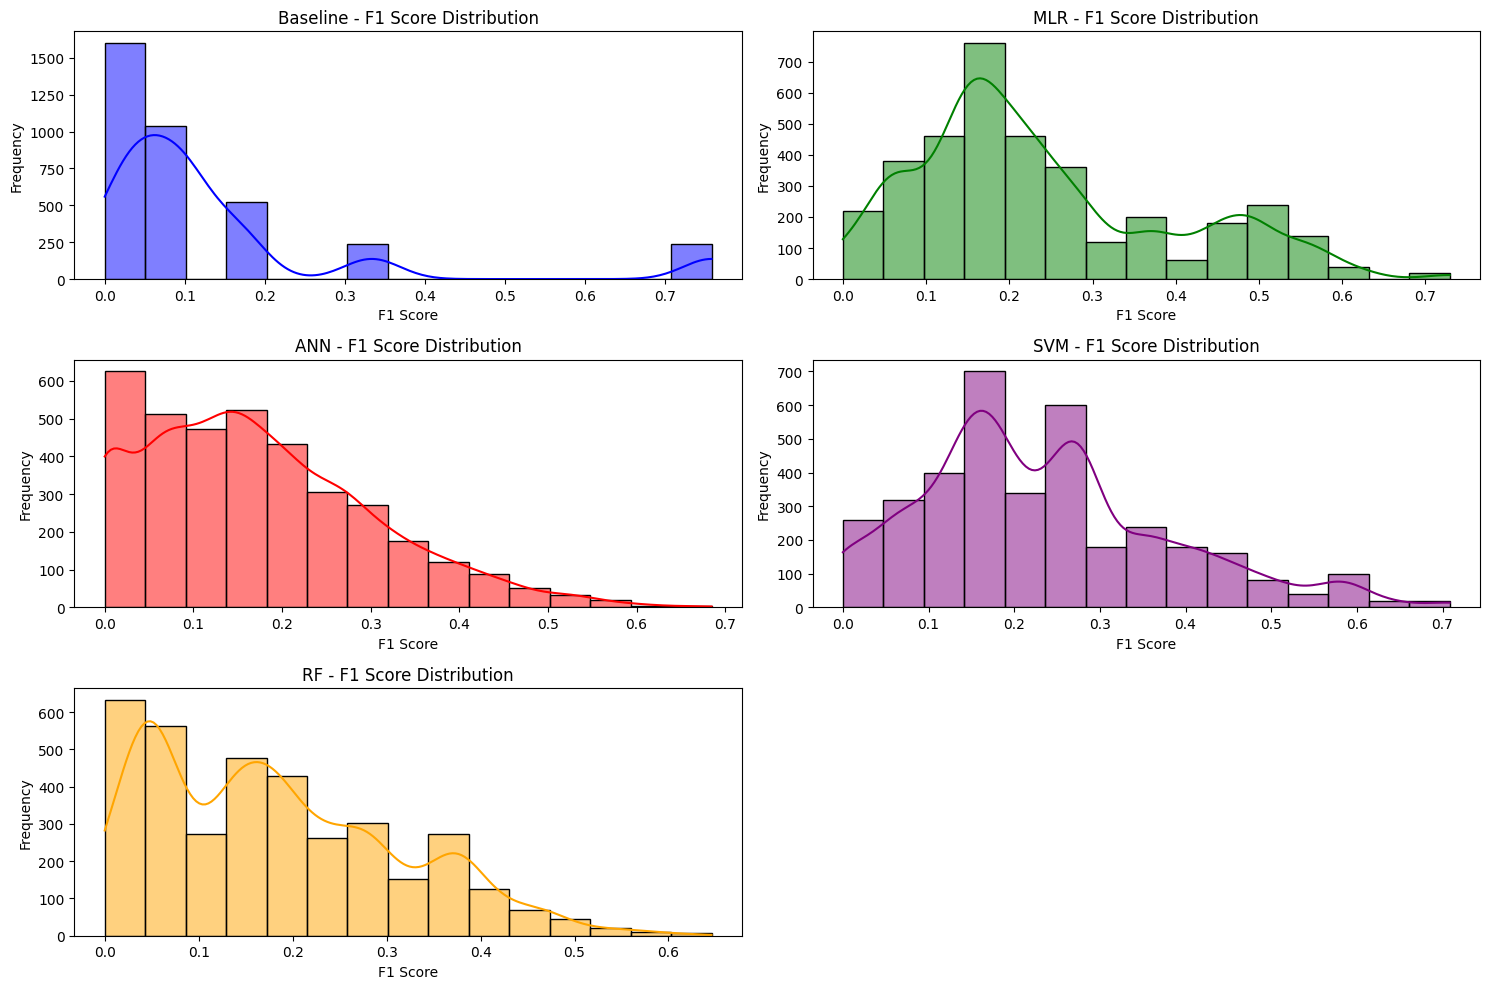

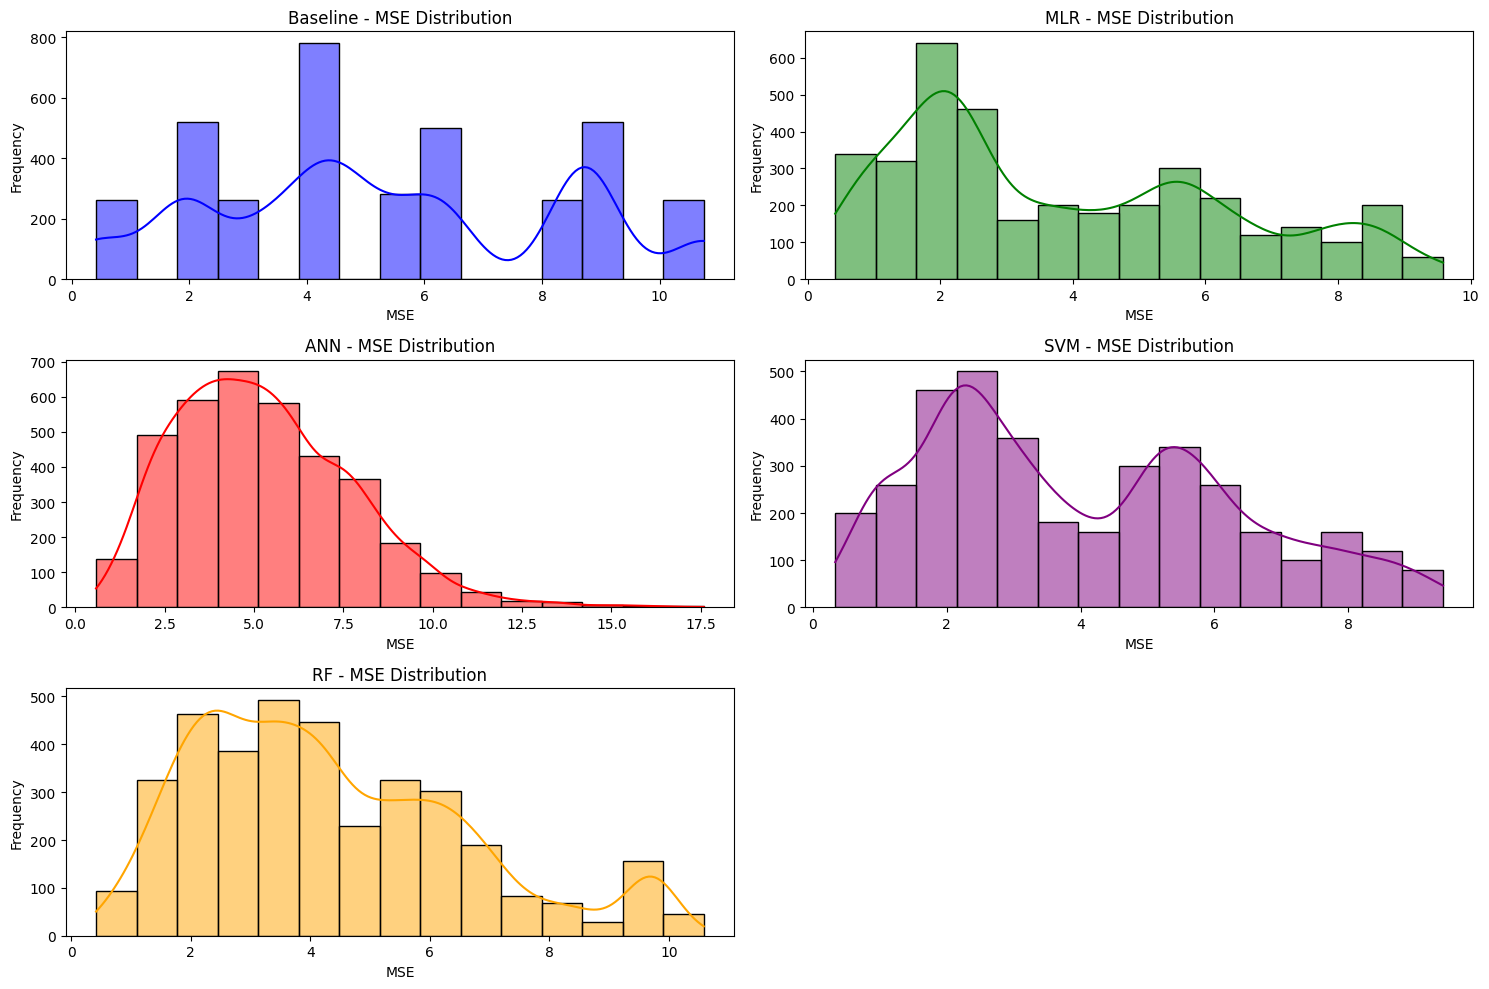

In [7]:
# Ploting histograms for F1 Score
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i + 1)
    sns.histplot(result['cv_f1_scores'], kde=True, color=colors[name], bins=15)
    plt.title(f'{name} - F1 Score Distribution')
    plt.xlabel('F1 Score')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plotting histograms for MSE
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i + 1)
    sns.histplot(result['cv_mse_scores'], kde=True, color=colors[name], bins=15)
    plt.title(f'{name} - MSE Distribution')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

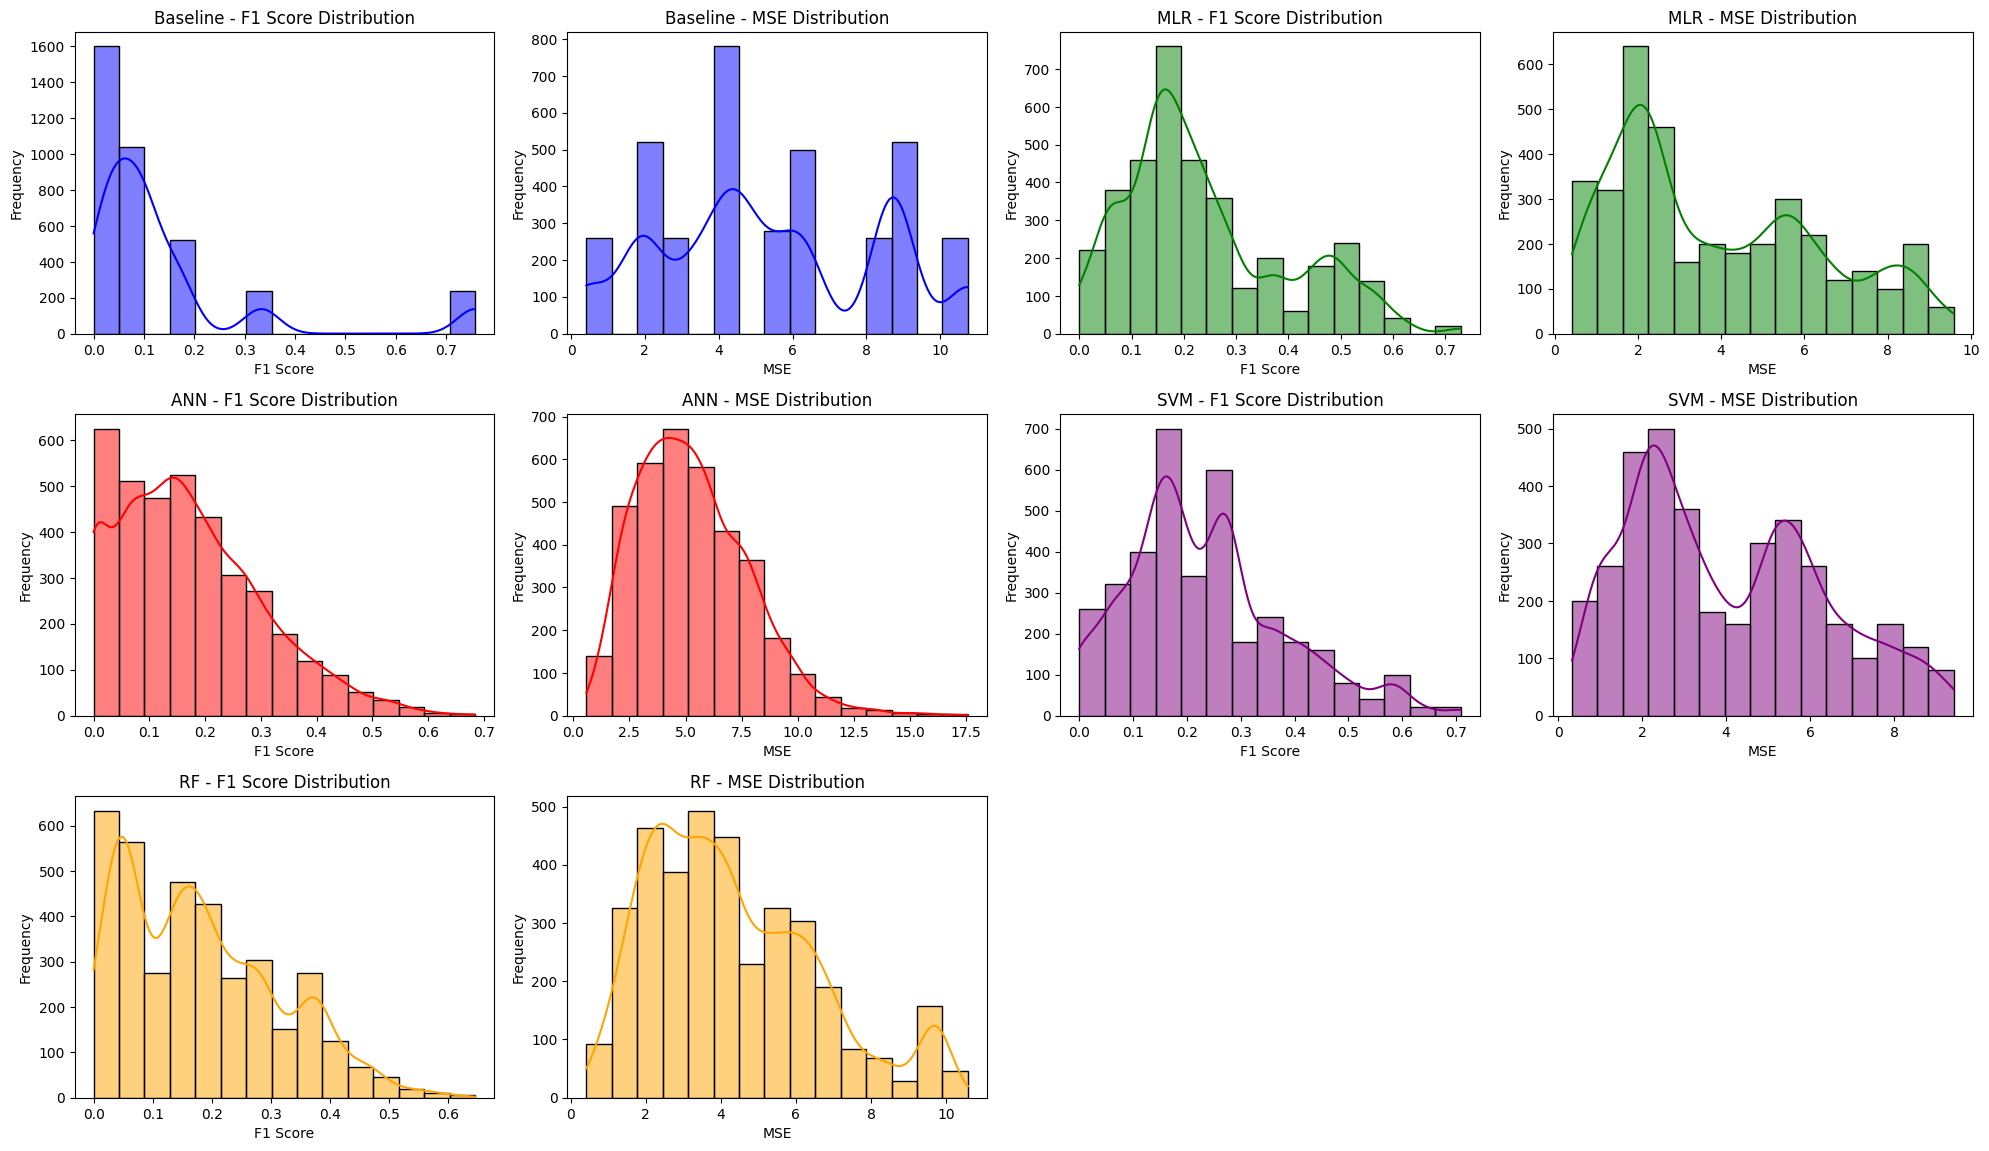

In [8]:
# Plotring them side by side
plt.figure(figsize=(20, 15))

plot_idx = 1
for name, result in results.items():
    plt.subplot(4, 4, plot_idx)
    sns.histplot(result['cv_f1_scores'], kde=True, color=colors[name], bins=15)
    plt.title(f'{name} - F1 Score Distribution')
    plt.xlabel('F1 Score')
    plt.ylabel('Frequency')
    plot_idx += 1

    plt.subplot(4, 4, plot_idx)
    sns.histplot(result['cv_mse_scores'], kde=True, color=colors[name], bins=15)
    plt.title(f'{name} - MSE Distribution')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plot_idx += 1

plt.tight_layout()
plt.show()


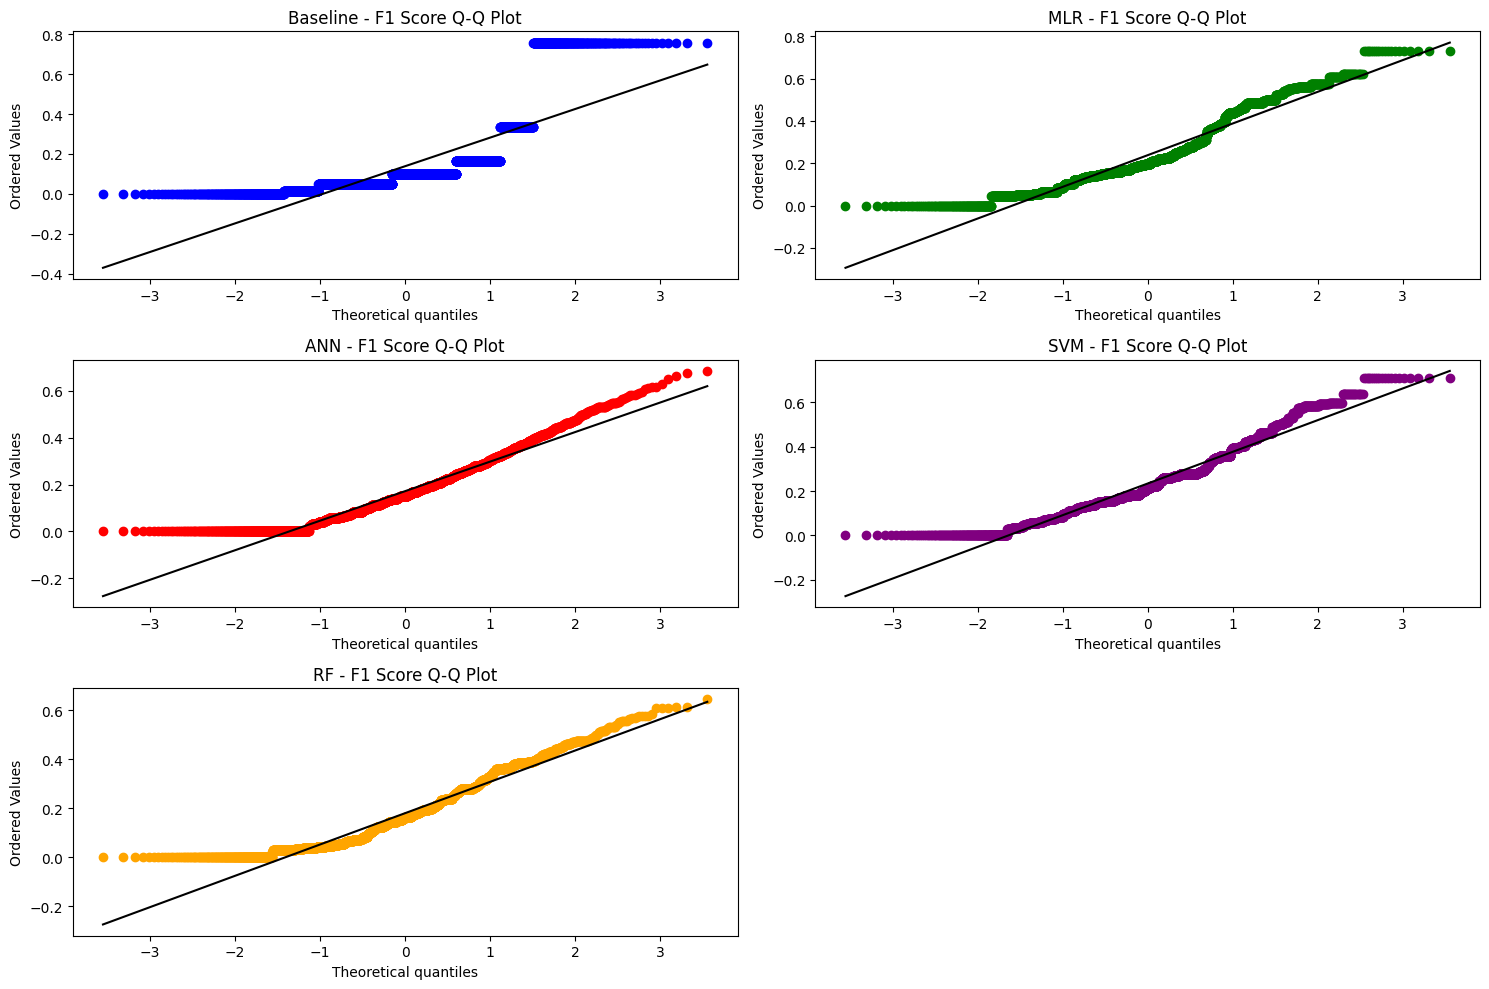

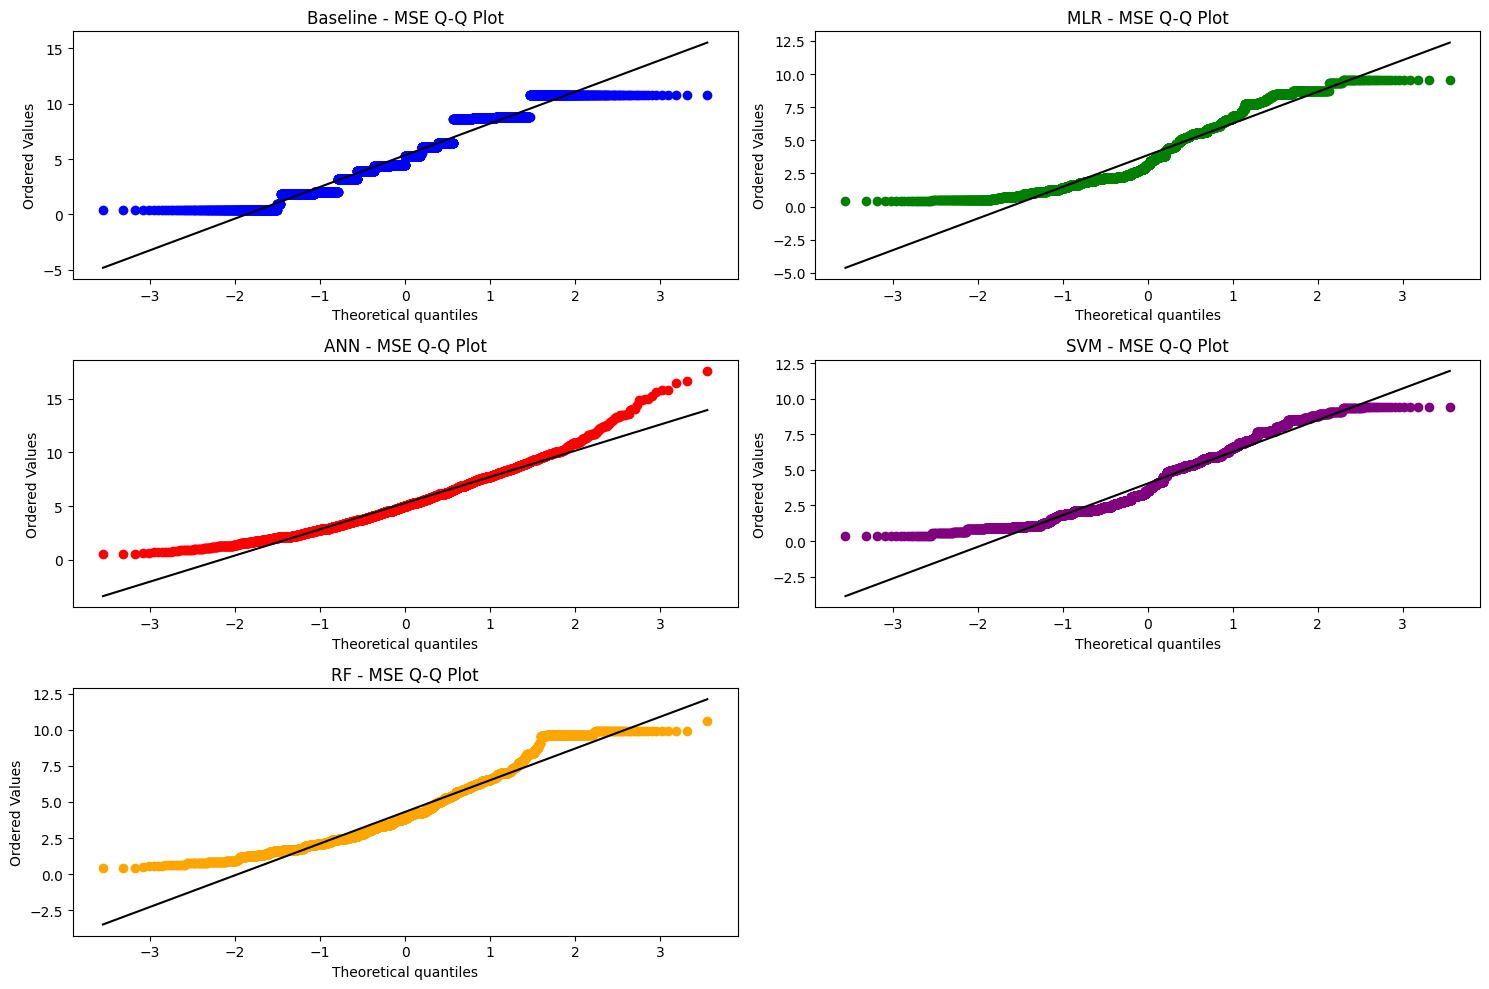

In [9]:
# Q-Q Plots for F1 Score
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i + 1)
    probplot(result['cv_f1_scores'], dist="norm", plot=plt)
    plt.title(f'{name} - F1 Score Q-Q Plot')
    plt.gca().get_lines()[0].set_color(colors[name])
    plt.gca().get_lines()[1].set_color('black')
plt.tight_layout()
plt.show()

# Q-Q Plots for MSE
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i + 1)
    probplot(result['cv_mse_scores'], dist="norm", plot=plt)
    plt.title(f'{name} - MSE Q-Q Plot')
    plt.gca().get_lines()[0].set_color(colors[name])
    plt.gca().get_lines()[1].set_color('black')
plt.tight_layout()
plt.show()

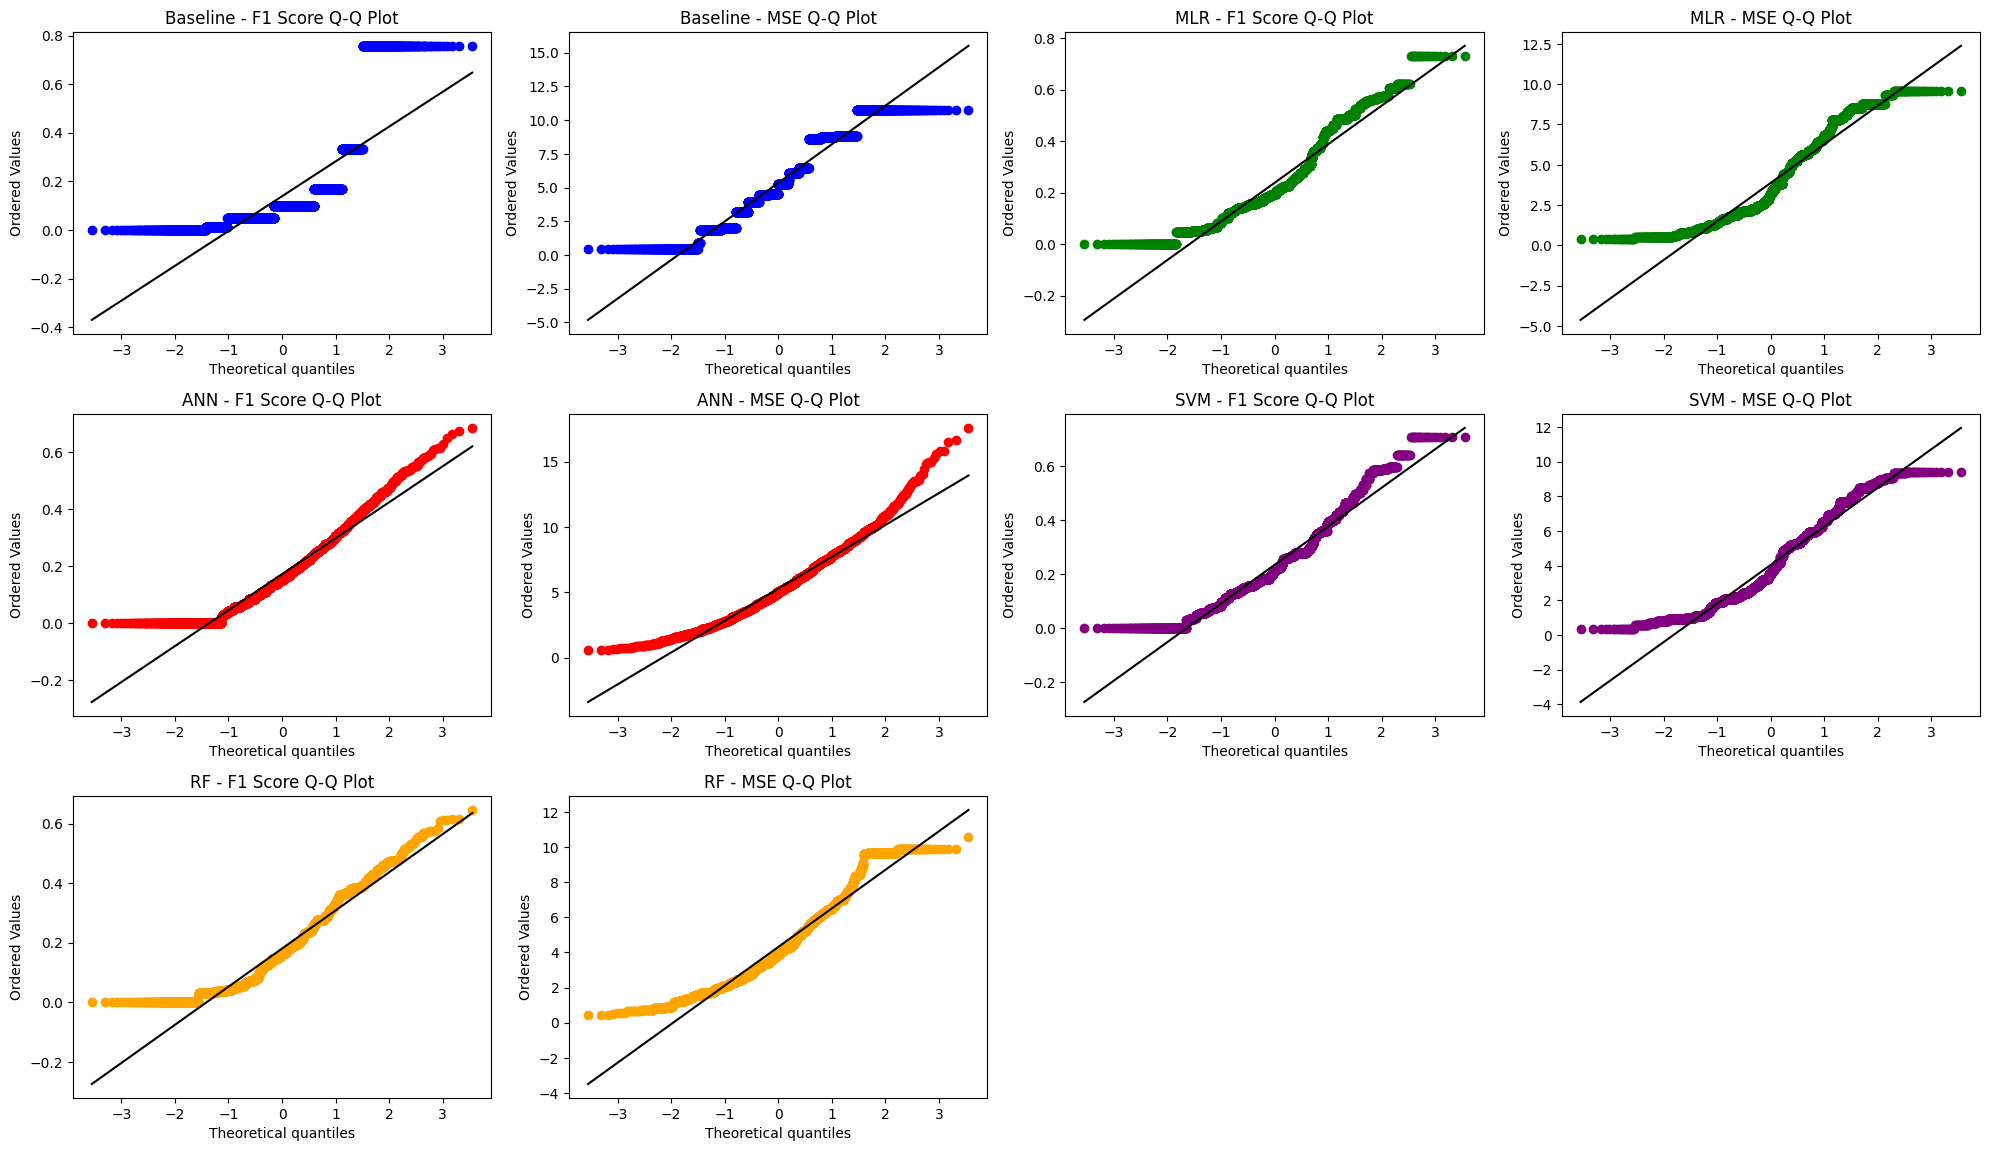

In [10]:
# Side by side
plt.figure(figsize=(20, 15))

plot_idx = 1
for name, result in results.items():
   
    plt.subplot(4, 4, plot_idx)
    probplot(result['cv_f1_scores'], dist="norm", plot=plt)
    plt.title(f'{name} - F1 Score Q-Q Plot')
    plt.gca().get_lines()[0].set_color(colors[name])
    plt.gca().get_lines()[1].set_color('black')
    plot_idx += 1

    plt.subplot(4, 4, plot_idx)
    probplot(result['cv_mse_scores'], dist="norm", plot=plt)
    plt.title(f'{name} - MSE Q-Q Plot')
    plt.gca().get_lines()[0].set_color(colors[name])
    plt.gca().get_lines()[1].set_color('black')
    plot_idx += 1

# Adjust layout
plt.tight_layout()
plt.show()


In [11]:
# Conducting Shapiro-Wilk Test for Normality
shapiro_results = {}

for name, result in results.items():
    f1_stat, f1_p = shapiro(result['cv_f1_scores'])
    mse_stat, mse_p = shapiro(result['cv_mse_scores'])
    shapiro_results[name] = {
        'f1_shapiro_stat': f1_stat,
        'f1_shapiro_p_value': f1_p,
        'mse_shapiro_stat': mse_stat,
        'mse_shapiro_p_value': mse_p
    }
    print(f'{name} - F1 Score Shapiro-Wilk Test: Statistic={f1_stat:.2f}, p-value={f1_p:.2e}')
    print(f'{name} - MSE Shapiro-Wilk Test: Statistic={mse_stat:.2f}, p-value={mse_p:.2e}')


Baseline - F1 Score Shapiro-Wilk Test: Statistic=0.61, p-value=1.45e-67
Baseline - MSE Shapiro-Wilk Test: Statistic=0.94, p-value=5.46e-35
MLR - F1 Score Shapiro-Wilk Test: Statistic=0.93, p-value=4.38e-38
MLR - MSE Shapiro-Wilk Test: Statistic=0.93, p-value=2.93e-39
ANN - F1 Score Shapiro-Wilk Test: Statistic=0.95, p-value=3.73e-34
ANN - MSE Shapiro-Wilk Test: Statistic=0.97, p-value=5.19e-28
SVM - F1 Score Shapiro-Wilk Test: Statistic=0.96, p-value=2.61e-31
SVM - MSE Shapiro-Wilk Test: Statistic=0.95, p-value=1.36e-33
RF - F1 Score Shapiro-Wilk Test: Statistic=0.94, p-value=4.47e-35
RF - MSE Shapiro-Wilk Test: Statistic=0.94, p-value=5.35e-35


In [12]:
# Collecting Shapiro-Wilk test results into a dataframe for easier visualisation
shapiro_results_dict = {
    'Model': list(shapiro_results.keys()),
    'F1 Shapiro Statistic': [res['f1_shapiro_stat'] for res in shapiro_results.values()],
    'F1 Shapiro p-value': [res['f1_shapiro_p_value'] for res in shapiro_results.values()],
    'MSE Shapiro Statistic': [res['mse_shapiro_stat'] for res in shapiro_results.values()],
    'MSE Shapiro p-value': [res['mse_shapiro_p_value'] for res in shapiro_results.values()]
}

shapiro_results_df = pd.DataFrame(shapiro_results_dict)
shapiro_results_df.to_csv('Shapiro_Wilk_Test_Results.csv', index=False)
display(shapiro_results_df)

,Model,F1 Shapiro Statistic,F1 Shapiro p-value,MSE Shapiro Statistic,MSE Shapiro p-value
0,Baseline,0.612825,1.445261e-67,0.944453,5.455919e-35
1,MLR,0.930989,4.376681e-38,0.925250,2.930922e-39
2,ANN,0.947698,3.726800e-34,0.967289,5.186904e-28
3,SVM,0.957662,2.613878e-31,0.949797,1.358136e-33
4,RF,0.944109,4.474250e-35,0.944418,5.345860e-35


In [13]:
# Converting the scores to a list of lists for the Kruskal-Wallis test
f1_scores_list = [results[name]['cv_f1_scores'] for name in results.keys()]
mse_scores_list = [results[name]['cv_mse_scores'] for name in results.keys()]

# Kruskal-Wallis test for F1 scores
stat_f1, p_f1 = kruskal(*f1_scores_list)
print('Kruskal-Wallis Test for F1 Scores: Statistics=%.3f, p=%.3e' % (stat_f1, p_f1))

# Kruskal-Wallis test for MSE scores
stat_mse, p_mse = kruskal(*mse_scores_list)
print('Kruskal-Wallis Test for MSE Scores: Statistics=%.3f, p=%.3e' % (stat_mse, p_mse))

# Print for me
if p_f1 > 0.05:
    print('Fail to reject H0: No significant difference between models for F1 scores')
else:
    print('Reject H0: Significant difference between models for F1 scores')

if p_mse > 0.05:
    print('Fail to reject H0: No significant difference between models for MSE scores')
else:
    print('Reject H0: Significant difference between models for MSE scores')


Kruskal-Wallis Test for F1 Scores: Statistics=1979.569, p=0.000e+00
Kruskal-Wallis Test for MSE Scores: Statistics=988.803, p=9.531e-213
Reject H0: Significant difference between models for F1 scores
Reject H0: Significant difference between models for MSE scores


New significance level after Bonferroni correction: 5.000e-03


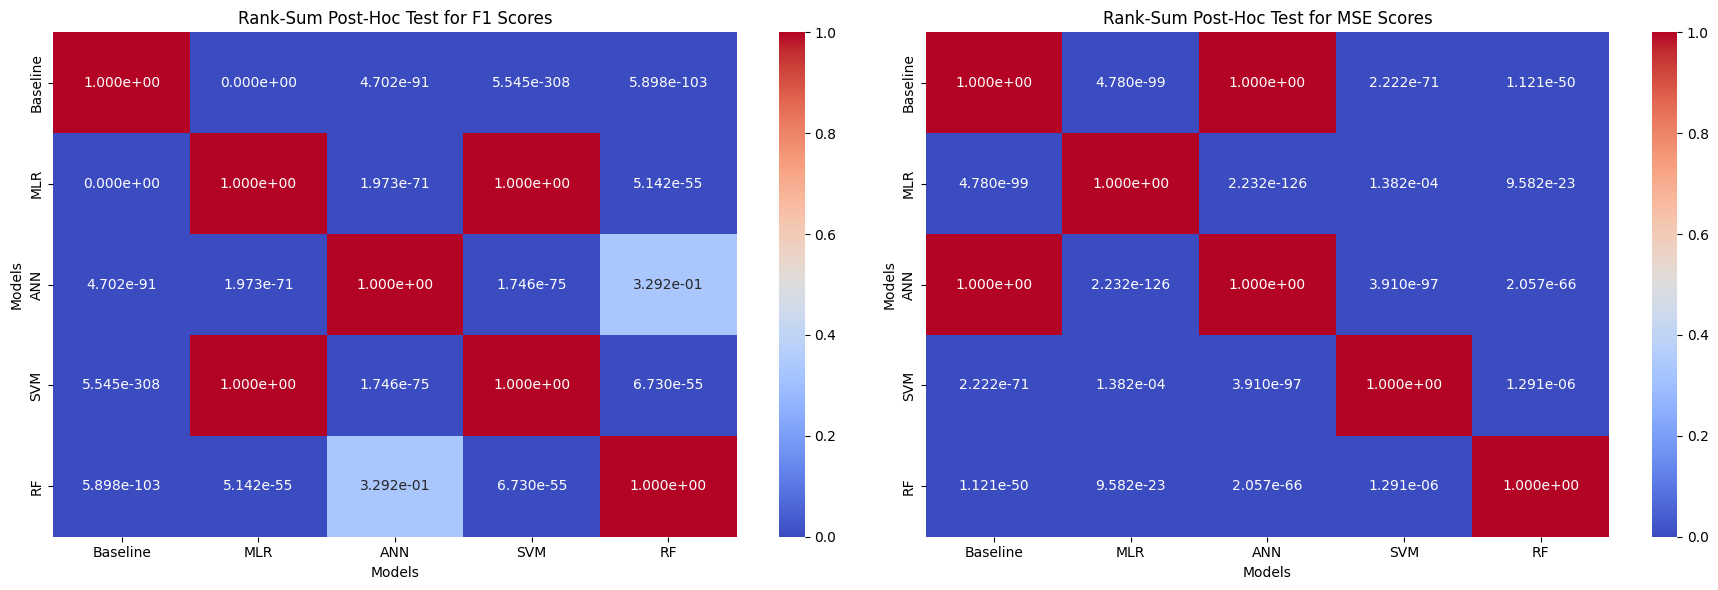

In [14]:
# Pairwise Wilcoxon Rank-Sum tests
f1_scores_list = [results[name]['cv_f1_scores'] for name in results.keys()]
mse_scores_list = [results[name]['cv_mse_scores'] for name in results.keys()]
model_names = list(results.keys())
num_models = len(model_names)

# p-values matrices with NaN are initialised
p_values_f1 = np.full((num_models, num_models), np.nan)
p_values_mse = np.full((num_models, num_models), np.nan)

# Pairwise Rank-Sum tests
for i in range(num_models):
    for j in range(i + 1, num_models):
        # For F1 scores
        stat_f1, p_f1 = ranksums(f1_scores_list[i], f1_scores_list[j])
        p_values_f1[i, j] = p_f1
        p_values_f1[j, i] = p_f1
        
        # For MSE scores
        stat_mse, p_mse = ranksums(mse_scores_list[i], mse_scores_list[j])
        p_values_mse[i, j] = p_mse
        p_values_mse[j, i] = p_mse

# Replacing NaN values with 1 (indicating no significant difference)
p_values_f1 = np.nan_to_num(p_values_f1, nan=1.0)
p_values_mse = np.nan_to_num(p_values_mse, nan=1.0)

# Applying Bonferroni correction for F1 scores if there are valid p-values
if p_values_f1.size > 0:
    p_values_f1_flat = p_values_f1.flatten()  
    _, p_values_f1_corrected, _, _ = multipletests(p_values_f1_flat, method='bonferroni') 
    p_values_f1_corrected = p_values_f1_corrected.reshape(num_models, num_models) 
else:
    p_values_f1_corrected = p_values_f1

# Applying Bonferroni correction for MSE scores if there are valid p-values
if p_values_mse.size > 0:
    p_values_mse_flat = p_values_mse.flatten()  # Flatten the matrix to a 1D array
    _, p_values_mse_corrected, _, _ = multipletests(p_values_mse_flat, method='bonferroni') 
    p_values_mse_corrected = p_values_mse_corrected.reshape(num_models, num_models) 
else:
    p_values_mse_corrected = p_values_mse

# Significance level after Bonferroni correction
alpha = 0.05
num_comparisons = (num_models * (num_models - 1)) / 2
new_alpha = 0.005
print(f'New significance level after Bonferroni correction: {new_alpha:.3e}')

# Heatmap visualisation
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap for F1 scores
sns.heatmap(p_values_f1_corrected, annot=True, fmt='.3e', cmap='coolwarm', ax=ax[0], xticklabels=model_names, yticklabels=model_names)
ax[0].set_title('Rank-Sum Post-Hoc Test for F1 Scores')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('Models')

# Heatmap for MSE scores
sns.heatmap(p_values_mse_corrected, annot=True, fmt='.3e', cmap='coolwarm', ax=ax[1], xticklabels=model_names, yticklabels=model_names)
ax[1].set_title('Rank-Sum Post-Hoc Test for MSE Scores')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('Models')

plt.tight_layout()
plt.show()


In [15]:
# Function to create LaTeX table from p-values matrix
def create_latex_table(p_values_matrix, model_names, table_caption, table_label):
    num_models = len(model_names)
    latex_str = "\\begin{table}[H]\n"
    latex_str += "\\centering\n"
    latex_str += f"\\caption{{{table_caption}}}\n"
    latex_str += f"\\label{{{table_label}}}\n"
    latex_str += "\\begin{tabular}{l" + "c" * num_models + "}\n"
    latex_str += "\\toprule\n"
    latex_str += " & " + " & ".join(model_names) + " \\\\\n"
    latex_str += "\\midrule\n"
    
    for i in range(num_models):
        row = [f"{model_names[i]}"] + [f"{p_values_matrix[i, j]:.3e}" if i != j else "-" for j in range(num_models)]
        latex_str += " & ".join(row) + " \\\\\n"
    
    latex_str += "\\bottomrule\n"
    latex_str += "\\end{tabular}\n"
    latex_str += "\\end{table}\n"
    
    return latex_str

# Create LaTeX tables for F1 and MSE corrected p-values
latex_table_f1 = create_latex_table(p_values_f1_corrected, model_names, "Wilcoxon Post-Hoc Test Corrected P-Values for F1 Scores", "tab:wilcoxon_f1")
latex_table_mse = create_latex_table(p_values_mse_corrected, model_names, "Wilcoxon Post-Hoc Test Corrected P-Values for MSE Scores", "tab:wilcoxon_mse")

# Print the LaTeX tables
print(latex_table_f1)
print(latex_table_mse)


\begin{table}[H]
\centering
\caption{Wilcoxon Post-Hoc Test Corrected P-Values for F1 Scores}
\label{tab:wilcoxon_f1}
\begin{tabular}{lccccc}
\toprule
 & Baseline & MLR & ANN & SVM & RF \\
\midrule
Baseline & - & 0.000e+00 & 4.702e-91 & 5.545e-308 & 5.898e-103 \\
MLR & 0.000e+00 & - & 1.973e-71 & 1.000e+00 & 5.142e-55 \\
ANN & 4.702e-91 & 1.973e-71 & - & 1.746e-75 & 3.292e-01 \\
SVM & 5.545e-308 & 1.000e+00 & 1.746e-75 & - & 6.730e-55 \\
RF & 5.898e-103 & 5.142e-55 & 3.292e-01 & 6.730e-55 & - \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Wilcoxon Post-Hoc Test Corrected P-Values for MSE Scores}
\label{tab:wilcoxon_mse}
\begin{tabular}{lccccc}
\toprule
 & Baseline & MLR & ANN & SVM & RF \\
\midrule
Baseline & - & 4.780e-99 & 1.000e+00 & 2.222e-71 & 1.121e-50 \\
MLR & 4.780e-99 & - & 2.232e-126 & 1.382e-04 & 9.582e-23 \\
ANN & 1.000e+00 & 2.232e-126 & - & 3.910e-97 & 2.057e-66 \\
SVM & 2.222e-71 & 1.382e-04 & 3.910e-97 & - & 1.291e-06 \\
RF & 1.121e-50 & 

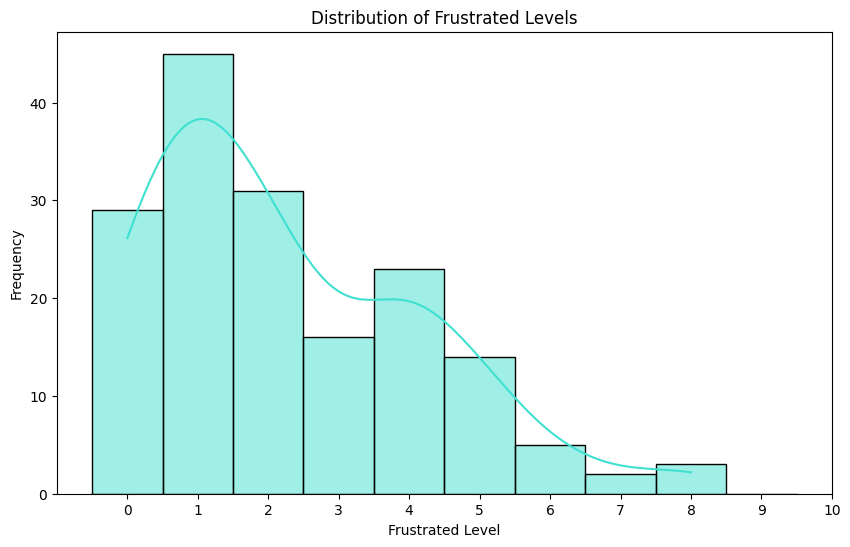

In [16]:
# Ploting distribution of Frustrated
plt.figure(figsize=(10, 6))
sns.histplot(df['Frustrated'], kde=True, bins=np.arange(-0.5, 10.5, 1), color='turquoise', edgecolor='black')
plt.title('Distribution of Frustrated Levels')
plt.xlabel('Frustrated Level')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(0, 11, 1))
plt.show()

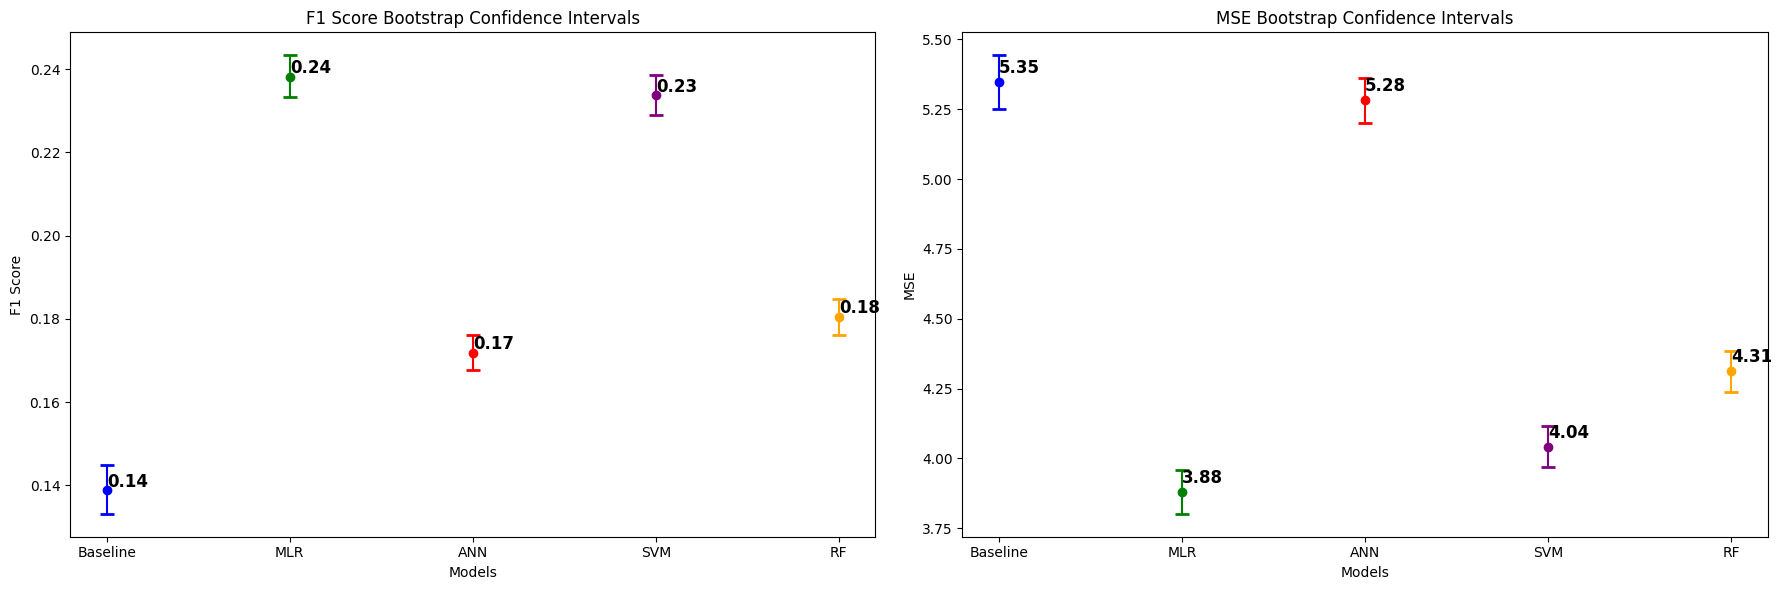

In [17]:
# Bootstrap confidence intervals for non-parametric data
def bootstrap_confidence_intervals(data, n_iterations=10000, confidence=0.95):
    n_size = len(data)
    means = []
    for _ in range(n_iterations):
        sample = resample(data, n_samples=n_size)
        means.append(np.mean(sample))
    lower = np.percentile(means, (1 - confidence) / 2 * 100)
    upper = np.percentile(means, (1 + confidence) / 2 * 100)
    mean = np.mean(means)
    return mean, lower, upper

# Bootstrap to calculate confidence intervals
n_iterations = 10000
bootstrap_conf_intervals = {
    name: {
        'f1_mean': 0, 'f1_lower': 0, 'f1_upper': 0,
        'mse_mean': 0, 'mse_lower': 0, 'mse_upper': 0
    }
    for name in results.keys()
}

for name in results.keys():
    f1_mean, f1_lower, f1_upper = bootstrap_confidence_intervals(results[name]['cv_f1_scores'], n_iterations=n_iterations)
    mse_mean, mse_lower, mse_upper = bootstrap_confidence_intervals(results[name]['cv_mse_scores'], n_iterations=n_iterations)
    bootstrap_conf_intervals[name]['f1_mean'] = f1_mean
    bootstrap_conf_intervals[name]['f1_lower'] = f1_lower
    bootstrap_conf_intervals[name]['f1_upper'] = f1_upper
    bootstrap_conf_intervals[name]['mse_mean'] = mse_mean
    bootstrap_conf_intervals[name]['mse_lower'] = mse_lower
    bootstrap_conf_intervals[name]['mse_upper'] = mse_upper

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# F1 Score CI
models = list(bootstrap_conf_intervals.keys())
f1_means = [bootstrap_conf_intervals[model]['f1_mean'] for model in models]
f1_errors = [(bootstrap_conf_intervals[model]['f1_mean'] - bootstrap_conf_intervals[model]['f1_lower'], 
              bootstrap_conf_intervals[model]['f1_upper'] - bootstrap_conf_intervals[model]['f1_mean']) for model in models]
f1_errors = np.array(f1_errors).T  

# Color coding
for i, model in enumerate(models):
    ax[0].errorbar(model, f1_means[i], yerr=[[f1_errors[0][i]], [f1_errors[1][i]]], fmt='o', capsize=5, capthick=2, color=colors[model], ecolor=colors[model])
    ax[0].text(i, f1_means[i] + 0.002, f'{f1_means[i]:.2f}', color='black', ha='left', va='center', fontsize=12, fontweight='bold')
ax[0].set_title('F1 Score Bootstrap Confidence Intervals')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('F1 Score')

# MSE CI
mse_means = [bootstrap_conf_intervals[model]['mse_mean'] for model in models]
mse_errors = [(bootstrap_conf_intervals[model]['mse_mean'] - bootstrap_conf_intervals[model]['mse_lower'], 
               bootstrap_conf_intervals[model]['mse_upper'] - bootstrap_conf_intervals[model]['mse_mean']) for model in models]
mse_errors = np.array(mse_errors).T  # Error bars need to be in separate arrays for upper and lower bounds

# Ploting each model with its right color
for i, model in enumerate(models):
    ax[1].errorbar(model, mse_means[i], yerr=[[mse_errors[0][i]], [mse_errors[1][i]]], fmt='o', capsize=5, capthick=2, color=colors[model], ecolor=colors[model])
    ax[1].text(i, mse_means[i] + 0.05, f'{mse_means[i]:.2f}', color='black', ha='left', va='center', fontsize=12, fontweight='bold')
ax[1].set_title('MSE Bootstrap Confidence Intervals')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('MSE')

plt.tight_layout()
plt.show()


In [22]:
### Checking for normality in log-transformed data
def log_transform(data):
    return np.log1p(data)

log_f1_scores = {name: log_transform(results[name]['cv_f1_scores']) for name in results.keys()}
log_mse_scores = {name: log_transform(results[name]['cv_mse_scores']) for name in results.keys()}

# Shapiro-Wilk test on the log-transformed data
log_shapiro_results = {}

for name in results.keys():
    f1_stat, f1_p = shapiro(log_f1_scores[name])
    mse_stat, mse_p = shapiro(log_mse_scores[name])
    log_shapiro_results[name] = {
        'log_f1_shapiro_stat': f1_stat,
        'log_f1_shapiro_p_value': f1_p,
        'log_mse_shapiro_stat': mse_stat,
        'log_mse_shapiro_p_value': mse_p
    }


log_shapiro_results_dict = {
    'Model': list(log_shapiro_results.keys()),
    'Log F1 Shapiro Statistic': [res['log_f1_shapiro_stat'] for res in log_shapiro_results.values()],
    'Log F1 Shapiro p-value': [res['log_f1_shapiro_p_value'] for res in log_shapiro_results.values()],
    'Log MSE Shapiro Statistic': [res['log_mse_shapiro_stat'] for res in log_shapiro_results.values()],
    'Log MSE Shapiro p-value': [res['log_mse_shapiro_p_value'] for res in log_shapiro_results.values()]
}

log_shapiro_results_df = pd.DataFrame(log_shapiro_results_dict)
log_shapiro_results_df.to_csv('Log_Shapiro_Wilk_Test_Results.csv', index=False)
log_shapiro_results_df

,Model,Log F1 Shapiro Statistic,Log F1 Shapiro p-value,Log MSE Shapiro Statistic,Log MSE Shapiro p-value
0,Baseline,0.677761,5.139738e-64,0.910305,5.234152e-42
1,MLR,0.952997,1.061711e-32,0.961458,4.369960e-30
2,ANN,0.962856,1.301338e-29,0.991331,4.310383e-14
3,SVM,0.976890,7.090724e-24,0.965632,1.253968e-28
4,RF,0.956209,9.361964e-32,0.987110,1.025476e-17


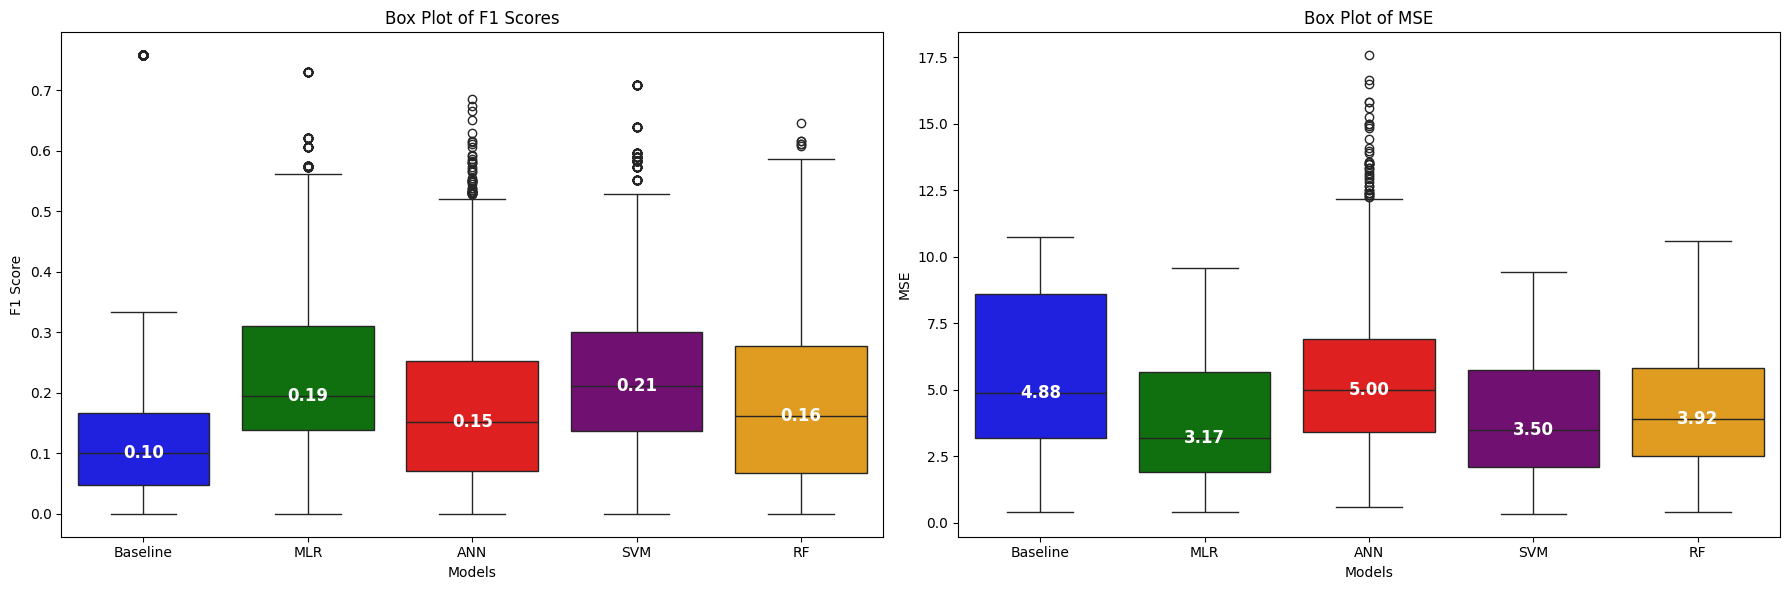

In [19]:
f1_scores_df = pd.DataFrame({name: results[name]['cv_f1_scores'] for name in results.keys()})
mse_scores_df = pd.DataFrame({name: results[name]['cv_mse_scores'] for name in results.keys()})

# Defining colors for each model again
colors = {
    'Baseline': 'blue',
    'MLR': 'green',
    'ANN': 'red',
    'SVM': 'purple',
    'RF': 'orange'
}

# box plots f1
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Box plot for F1 Scores
sns.boxplot(data=f1_scores_df, ax=ax[0], palette=colors)
ax[0].set_title('Box Plot of F1 Scores')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('F1 Score')

# Show median values on the F1 Score box plot
medians_f1 = f1_scores_df.median()
for i, model in enumerate(f1_scores_df.columns):
    ax[0].text(i, medians_f1[model], f'{medians_f1[model]:.2f}', color='white', ha='center', va='center', fontsize=12, fontweight='bold')

# Box plot for MSE
sns.boxplot(data=mse_scores_df, ax=ax[1], palette=colors)
ax[1].set_title('Box Plot of MSE')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('MSE')

# Show median values on the MSE box plot
medians_mse = mse_scores_df.median()
for i, model in enumerate(mse_scores_df.columns):
    ax[1].text(i, medians_mse[model], f'{medians_mse[model]:.2f}', color='white', ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [20]:
std_devs = {
    'f1_scores': {},
    'mse_scores': {}
}

means = {
    'f1_scores': {},
    'mse_scores': {}
}

# Standard deviation and mean for each model
for model_name, metrics in results.items():

    f1_scores_array = np.array(metrics['cv_f1_scores'])
    mse_scores_array = np.array(metrics['cv_mse_scores'])
    
    # Standard deviations across the different seeds
    f1_std_dev = np.std(f1_scores_array, axis=0)
    mse_std_dev = np.std(mse_scores_array, axis=0)
    
    # Means across the different seeds
    f1_mean = np.mean(f1_scores_array, axis=0)
    mse_mean = np.mean(mse_scores_array, axis=0)
    
    std_devs['f1_scores'][model_name] = f1_std_dev
    std_devs['mse_scores'][model_name] = mse_std_dev
    means['f1_scores'][model_name] = f1_mean
    means['mse_scores'][model_name] = mse_mean

# Coefficient of Variation (CV)
cv = {
    'f1_scores': {},
    'mse_scores': {}
}

for model_name in results.keys():
    cv['f1_scores'][model_name] = std_devs['f1_scores'][model_name] / means['f1_scores'][model_name]
    cv['mse_scores'][model_name] = std_devs['mse_scores'][model_name] / means['mse_scores'][model_name]

# Print
print("Standard Deviations for F1 Scores:")
for model_name, std_dev in std_devs['f1_scores'].items():
    print(f"{model_name}: {std_dev:.3f}")

print("\nStandard Deviations for MSE Scores:")
for model_name, std_dev in std_devs['mse_scores'].items():
    print(f"{model_name}: {std_dev:.3f}")

print("\nCoefficient of Variation for F1 Scores:")
for model_name, cv_value in cv['f1_scores'].items():
    print(f"{model_name}: {cv_value:.3f}")

print("\nCoefficient of Variation for MSE Scores:")
for model_name, cv_value in cv['mse_scores'].items():
    print(f"{model_name}: {cv_value:.3f}")


cv_std_df = pd.DataFrame({
    'F1 Std Dev': std_devs['f1_scores'],
    'F1 CV': cv['f1_scores'],
    'MSE Std Dev': std_devs['mse_scores'],
    'MSE CV': cv['mse_scores']
}).T

# Latex
latex_table = cv_std_df.to_latex(float_format="%.3f")
print(latex_table)

Standard Deviations for F1 Scores:
Baseline: 0.183
MLR: 0.155
ANN: 0.129
SVM: 0.146
RF: 0.132

Standard Deviations for MSE Scores:
Baseline: 2.939
MLR: 2.483
ANN: 2.476
SVM: 2.281
RF: 2.256

Coefficient of Variation for F1 Scores:
Baseline: 1.315
MLR: 0.651
ANN: 0.753
SVM: 0.623
RF: 0.729

Coefficient of Variation for MSE Scores:
Baseline: 0.549
MLR: 0.640
ANN: 0.469
SVM: 0.564
RF: 0.523
\begin{tabular}{lrrrrr}
\toprule
 & Baseline & MLR & ANN & SVM & RF \\
\midrule
F1 Std Dev & 0.183 & 0.155 & 0.129 & 0.146 & 0.132 \\
F1 CV & 1.315 & 0.651 & 0.753 & 0.623 & 0.729 \\
MSE Std Dev & 2.939 & 2.483 & 2.476 & 2.281 & 2.256 \\
MSE CV & 0.549 & 0.640 & 0.469 & 0.564 & 0.523 \\
\bottomrule
\end{tabular}



In [ ]:
# NOTE: Coding process has been aided with the use of Copilot and other LLMs for optimisation, efficiency, and debugging.